# Diterpene SVM 

## Introduction

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import iqr

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

The distribution of these diterpene classes is heavily skewed, with some classes having only one example.
The first four columns a0, a1, a2, a3 store the aggregated multiplicity count of the atom. The possible multiplicities are: s (singlet), d( doublet), t (triplet) and q (quartet). The following columns then specify first the type of multiplicity and then the respective frequency measure repeatedly. The last column a45c stores the classes.

Shape: (1202, 45)
Head:    a0  a1  a2  a3 a5      a6 a7     a8 a9    a10  ...    a36  a37    a38  a39  \
0   3   3   9   5  t   44.30  d  57.30  q  32.50  ...  39.80    t  35.30    t   
1   3   4   8   5  t  127.29  q  72.39  t  20.19  ...  59.29    t  34.68    s   
2   3   4   9   4  t   19.30  q  16.30  d  44.20  ...  39.80    t  37.50    q   

     a40  a41   a42  a43   a44  a45c  
0  41.10    t  35.7    t  30.9   22c  
1  38.43    t  35.5    d  48.3    3c  
2  67.10    t  19.6    q  70.5    3c  

[3 rows x 45 columns]


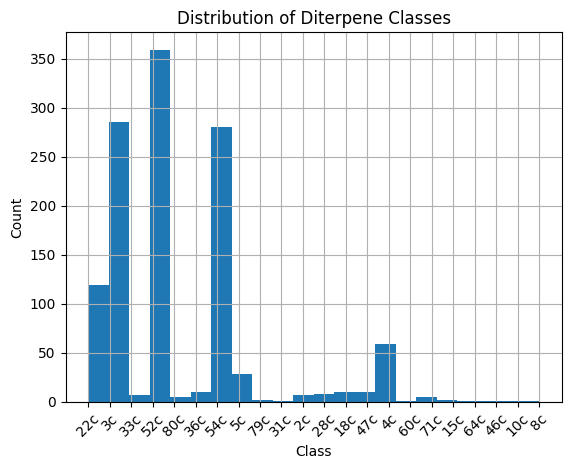

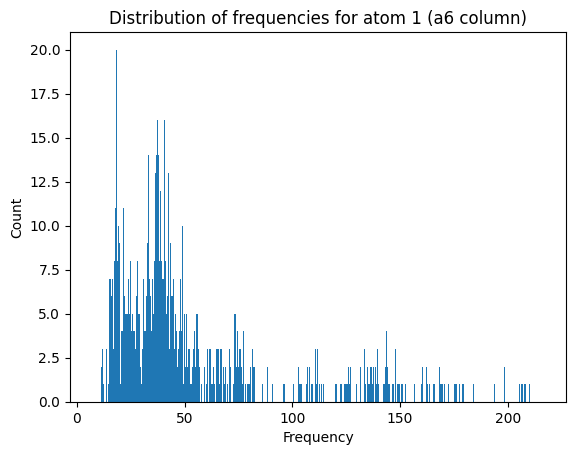

In [20]:
data = pd.read_csv("diterpene_shuf.csv")

# Shuffling
data = data.sample(frac=1, random_state=123).reset_index(drop=True)  
data = data.drop(["a4"], axis=1)

print("Shape:", data.shape)
print("Head:", data.head(3))

# Classes distribution
ax = data["a45c"].hist(bins=data["a45c"].nunique())
ax.set_title('Distribution of Diterpene Classes')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Frequency distribution
plt.hist(data["a6"], data["a6"].nunique())
plt.title("Distribution of frequencies for atom 1 (a6 column)")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()

## SVM

To solve this problem with machine learning techniques, the most important fact is that the structure of the molecule is independent of the order of specified multiplicities and their peaks. This aspect poses a challenge because the data, in its original form, cannot be directly used with standard machine learning methods that depend on the order of data. To overcome this, the data must either be aggregated or a special permutation-invariant method must be applied. In the first part of this project, we will address this by creating statistical features for each multiplicity, which will then be used to make predictions using a Support Vector Machine (SVM).



### Aggregated/Statistical Features

First various different permutation invariant statistics for each multiplicity level were tried out, using these as features for training a SVM with standard kernels. The optimal kernels and hyperparameters were selected by using standard grid search.

The most effective statistics were the mean, sum, minimum and maximum values, and the interquartile range (IQR). When combined, these statistics led to the highest accuracy, approximately 0.91, on the reserved test set. Notably, incorporating other statistics like quartiles, variance, median, and range did not improve accuracy, even when all possible combinations of statistics were evaluated.

In [21]:
data = pd.read_csv("diterpene_shuf.csv")
data = data.sample(frac=1, random_state=123).reset_index(drop=True)

# Dropping the expert features
data = data.drop(["a0", "a1", "a2", "a3", "a4"], axis=1)
X = data.drop(["a45c"], axis=1)
y = data['a45c']
X['sum_s'] = 0
X['sum_t'] = 0
X['sum_q'] = 0
X['sum_d'] = 0
X['mean_s'] = 0
X['mean_t'] = 0
X['mean_q'] = 0
X['mean_d'] = 0

# Sum
for i in range(0, X.shape[1]-8, 2):
    X.loc[X.iloc[:, i] == 's', 'sum_s'] += X.iloc[:, i + 1]
    X.loc[X.iloc[:, i] == 't', 'sum_t'] += X.iloc[:, i + 1]
    X.loc[X.iloc[:, i] == 'q', 'sum_q'] += X.iloc[:, i + 1]
    X.loc[X.iloc[:, i] == 'd', 'sum_d'] += X.iloc[:, i + 1]

# Mean
X['mean_s'] = X['sum_s'] / (X == 's').sum(axis=1)
X['mean_t'] = X['sum_t'] / (X == 't').sum(axis=1)
X['mean_q'] = X['sum_q'] / (X == 'q').sum(axis=1)
X['mean_d'] = X['sum_d'] / (X == 'd').sum(axis=1)

"""
# variance
for multiplicity in ['s', 't', 'q', 'd']:
    temp_values = []
    for i in range(0, X.shape[1]-8, 2):
        temp_values.extend(X.loc[X.iloc[:, i] == multiplicity, X.columns[i + 1]].values)
    X['variance_' + multiplicity] = np.var(temp_values)
"""

# Min-max
for multiplicity in ['s', 't', 'q', 'd']:
    X['min_' + multiplicity] = np.inf
    X['max_' + multiplicity] = -np.inf

for i in range(0, X.shape[1]-12, 2):
    for multiplicity in ['s', 't', 'q', 'd']:
        min_col = 'min_' + multiplicity
        max_col = 'max_' + multiplicity
        current_col = X.iloc[:, i + 1]

        X.loc[X.iloc[:, i] == multiplicity, min_col] = \
            current_col.where(current_col < X[min_col], X[min_col])

        X.loc[X.iloc[:, i] == multiplicity, max_col] = \
            current_col.where(current_col > X[max_col], X[max_col])
        
"""
# Range
for multiplicity in ['s', 't', 'q', 'd']:
    X['range_' + multiplicity] = 0

for multiplicity in ['s', 't', 'q', 'd']:
    X['range_' + multiplicity] = X['max_' + multiplicity] - X['min_' + multiplicity]
"""

# IQR
for multiplicity in ['s', 't', 'q', 'd']:
    X['iqr_' + multiplicity] = 0
for i in range(X.shape[0]):
    for multiplicity in ['s', 't', 'q', 'd']:
        values = [X.iloc[i, j+1] for j in range(0, X.shape[1]-8, 2) if X.iloc[i, j] == multiplicity]
        if values:
            X.at[i, 'iqr_' + multiplicity] = iqr(values)

"""
# Median
X['median_s'] = 0
X['median_t'] = 0
X['median_q'] = 0
X['median_d'] = 0

for multiplicity in ['s', 't', 'q', 'd']:
    temp_values = []
    for i in range(0, X.shape[1]-12, 2):
        temp_values.extend(X.loc[X.iloc[:, i] == multiplicity, X.columns[i + 1]].values)
    X['median_' + multiplicity] = np.median(temp_values)
"""

# Replace infinities with zeros if there were no entries for some multiplicities
X.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
X.replace([], 0, inplace=True)

In [22]:
# Select newly created features
X_new = X.iloc[:, 40:]
# X_new = X_new.drop(X_new.columns[8:17], axis=1)
print(X_new.head(3))
print(X_new.shape)

    sum_s  sum_t   sum_q   sum_d     mean_s     mean_t  mean_q     mean_d  \
0  103.90  458.8  260.00  235.90  34.633333  50.977778  52.000  78.633333   
1  119.84  448.7  193.36  245.02  39.946667  56.087500  38.672  61.255000   
2  135.30  293.5  332.80  190.40  45.100000  32.611111  83.200  47.600000   

   min_s  max_s  min_t   max_t  min_q   max_q  min_d   max_d  iqr_s    iqr_t  \
0  31.00  39.80  18.60  199.40   17.9  165.50   50.2  128.40  4.400  10.2000   
1  37.96  43.45  17.96  132.63   17.7   72.39   48.3   83.94  2.745  31.5525   
2  39.80  50.50  19.30   45.90   16.3  178.90   38.8   55.90  5.350  18.0000   

   iqr_q  iqr_d  
0  11.10  39.10  
1  41.28  17.85  
2  43.20   9.75  
(1202, 20)


In [23]:
import warnings
# Filter out FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Validation split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=123)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

param_grid = {
    'C': [ 0.1, 1, 10, 20],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5],  
    'coef0': [0, 1,]  
}

svm = SVC(random_state=123)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5, verbose = 1)
grid_search.fit(X_train_std, y_train)

best_params = grid_search.best_params_
svm.set_params(**best_params)
svm.fit(X_train_std, y_train)

# evaluation
y_test_pred = svm.predict(X_test_std)
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)
print("Best parametwrs:", best_params)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/opt/homebrew/Caskroom/miniconda/base/envs/standard/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.91701244813278
Best parametwrs: {'C': 20, 'coef0': 1, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'}


### Histograms

For the second part, I binned the frequencies for each multiplicity in each each row to create histograms with the goal of capturing the the frequency distribution of each sample. The training is again with the standard kernels and gridsearchCV. After trying out several different bin numbers, 10 bins performed the best, resulting in a test accuracy of ~ 0.86.

In [24]:
data = pd.read_csv("diterpene_shuf.csv")
data = data.sample(frac=1, random_state=123).reset_index(drop=True)

# Drop the expert features
data = data.drop(["a0", "a1", "a2", "a3", "a4"], axis=1)
X = data.drop(["a45c"], axis=1)
y = data['a45c']

def create_histogram_features(X_raw, num_bins=10):
    X_hist = pd.DataFrame()
    multiplicities = ['s', 't', 'q', 'd']

    for i in range(len(X_raw)):
        row = X_raw.iloc[i]
        histograms = [] 
        for multiplicity in multiplicities:
            # Reset the index for boolean indexing
            row_multiplicity = row[::2].reset_index(drop=True)
            row_frequencies = row[1::2].reset_index(drop=True)
            frequencies = row_frequencies[row_multiplicity == multiplicity]

            # Calculate histogram
            hist, _ = np.histogram(frequencies, bins=num_bins, range=(0, frequencies.max() if not frequencies.empty else 1))
            histograms.append(hist)
        
        # Concatenate all histograms for current row
        histogram_row = pd.DataFrame(np.concatenate(histograms).reshape(1, -1), 
                                     columns=[f'hist_{multiplicity}_{k}' for multiplicity in multiplicities for k in range(num_bins)])
        X_hist = pd.concat([X_hist, histogram_row])

    X_hist.fillna(0, inplace=True)
    return X_hist

X_hist = create_histogram_features(X, num_bins=10)
# print(X_hist.head())


In [25]:
# Validation split
X_train, X_test, y_train, y_test = train_test_split(X_hist, y, test_size=0.2, random_state=123)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

param_grid = {
    'C': [ 0.1, 1, 10, 20],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5], 
    'coef0': [0, 1,] 
}

# Grid search
svm = SVC(random_state=123)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5, verbose = 1)
grid_search.fit(X_train_std, y_train)

best_params = grid_search.best_params_
svm.set_params(**best_params)
svm.fit(X_train_std, y_train)

# Evaluation
y_test_pred = svm.predict(X_test_std)
accuracy = accuracy_score(y_test, y_test_pred)
print(accuracy)
print(best_params)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/opt/homebrew/Caskroom/miniconda/base/envs/standard/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0.8630705394190872
{'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}


###  Combination

Finally, the best result of ~0.93 test accuracy was achieved by combining both the statistical features as well as histograms with 6 bins.

In [26]:
data = pd.read_csv("diterpene_shuf.csv")
data = data.sample(frac=1, random_state=123).reset_index(drop=True)

# Dropping the expert features
data = data.drop(["a0", "a1", "a2", "a3", "a4"], axis=1)

X = data.drop(["a45c"], axis=1)
y = data['a45c']

X_stats = X_new
X_stats.reset_index(drop=True, inplace=True)
X_hist = create_histogram_features(X, num_bins=6)
print(X_hist.shape)
X_hist.reset_index(drop=True, inplace=True)
X_best = pd.concat([X_stats, X_hist], axis=1)
print(X_best.shape)
print(X_best.head(3))

(1202, 24)
(1202, 44)
    sum_s  sum_t   sum_q   sum_d     mean_s     mean_t  mean_q     mean_d  \
0  103.90  458.8  260.00  235.90  34.633333  50.977778  52.000  78.633333   
1  119.84  448.7  193.36  245.02  39.946667  56.087500  38.672  61.255000   
2  135.30  293.5  332.80  190.40  45.100000  32.611111  83.200  47.600000   

   min_s  max_s  ...  hist_q_2  hist_q_3  hist_q_4  hist_q_5  hist_d_0  \
0  31.00  39.80  ...         0         0         0         1         0   
1  37.96  43.45  ...         1         0         1         1         0   
2  39.80  50.50  ...         2         0         0         1         0   

   hist_d_1  hist_d_2  hist_d_3  hist_d_4  hist_d_5  
0         0         2         0         0         1  
1         0         0         2         1         1  
2         0         0         0         2         2  

[3 rows x 44 columns]


In [27]:
# Validation split
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=123)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


param_grid = {
    'C': [ 0.1, 1, 10, 20, 50],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5],  
    'coef0': [0, 1,]  
}

svm = SVC(random_state=123)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5, verbose = 1)
grid_search.fit(X_train_std, y_train)

best_params = grid_search.best_params_
svm.set_params(**best_params)
svm.fit(X_train_std, y_train)

# Evaluation
y_test_pred = svm.predict(X_test_std)
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)
print("Best parameters:", best_params)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


/opt/homebrew/Caskroom/miniconda/base/envs/standard/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.9336099585062241
Best parameters: {'C': 20, 'coef0': 0, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
